In [22]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import torch
import bvcopula
import select_copula
import utils
from vine import CVine

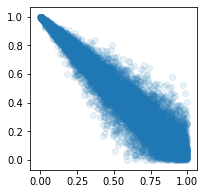

In [23]:
# №check the accuracy of ccdf-1(ccdf)
plt.figure(figsize=(3,3))
copula = bvcopula.ClaytonCopula(torch.ones(10000)*(9.4),rotation='90°')
S = copula.sample()
plt.scatter(*S.T,alpha=0.1)
S1 = S.clone()
S1[...,0] = copula.ccdf(S1)
S2 = copula.ppcf(S1)
(S[...,0]-S2).abs().max()
mask = (S[...,0]-S2).abs()>1e-4
plt.scatter(S[...,0][mask],S[...,1][mask])

In [24]:
NSamp=10000
device = 'cuda:0'
x = torch.linspace(0.,1.,NSamp).numpy()
test_x = torch.tensor(x).float().cuda(device=device)

copula_model = utils.create_model('thetas',[bvcopula.GaussianCopula_Likelihood()],x.shape[0])
Y = copula_model.sample().cpu().numpy().squeeze()

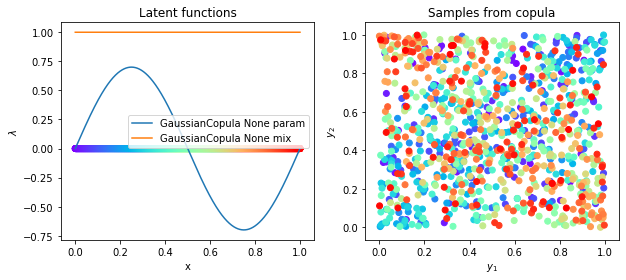

In [25]:
#plot model parameters and samples
colors = cm.rainbow(x)
fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

fp = utils.LatentSpacePlot('Latent functions','x','$\lambda$',lambdaf)
fp.plot(x,copula_model, colors=colors)

sp = utils.PlotSamples('Samples from copula','$y_1$','$y_2$',samples)
sp.plot(copula_model, Y[::10], colors[::10])

fig.show()

In [26]:
copula_model01 = utils.create_model('thetas',[bvcopula.ClaytonCopula_Likelihood(rotation='90°'), bvcopula.ClaytonCopula_Likelihood(rotation='0°')],x.shape[0],device=device)
copula_model02 = utils.create_model('thetas',[bvcopula.FrankCopula_Likelihood()],x.shape[0],device=device)
# copula_model03 = utils.create_model('thetas',[bvcopula.GumbelCopula_Likelihood(rotation='90°')],x.shape[0],device=device)
# copula_model12 = utils.create_model('thetas',[bvcopula.GaussianCopula_Likelihood()],x.shape[0],device=device)
# copula_model13 = utils.create_model('thetas',[bvcopula.GumbelCopula_Likelihood(rotation='180°')],x.shape[0],device=device)
copula_model23 = utils.create_model('thetas',[bvcopula.GumbelCopula_Likelihood(rotation='270°')],x.shape[0],device=device)
layers = [[copula_model01, copula_model02],[copula_model23]]

In [27]:
vine = CVine(layers,x,device=device)
V = vine.sample()

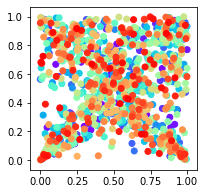

In [28]:

Y_new = np.array([V[0][::10,0].cpu().numpy(),V[0][::10,1].cpu().numpy()]).T

plt.figure(figsize=(3,3))
colors = cm.rainbow(x)
plt.scatter(*Y_new.T, color=colors[::10])

In [29]:
path = '/home/nina/CopulaGP/synthetic_data'
exp_pref='SCVine'
data = {}
y = V[0].cpu().numpy()
assert np.all(y>0) & np.all(y<1)
data['X'] = x
data['Y'] = y

with open(f"{path}/{exp_pref}_layer0.pkl",'wb') as f:
    pkl.dump(data,f)

In [129]:
with open(f"{path}/{exp_pref}_layer1.pkl",'rb') as f:
    layer1=pkl.load(f)

([array([ 961.,  992.,  986.,  968., 1083., 1109., 1008.,  966.,  959.,
          968.]),
  array([1003., 1024., 1004., 1062.,  932., 1010.,  954., 1004.,  999.,
         1008.]),
  array([ 951., 1048., 1036.,  996.,  959., 1002., 1014., 1045.,  980.,
          969.])],
 array([1.73321445e-04, 1.00147605e-01, 2.00121880e-01, 3.00096154e-01,
        4.00070459e-01, 5.00044703e-01, 6.00019038e-01, 6.99993312e-01,
        7.99967587e-01, 8.99941862e-01, 9.99916136e-01], dtype=float32),
 <a list of 3 Lists of Patches objects>)

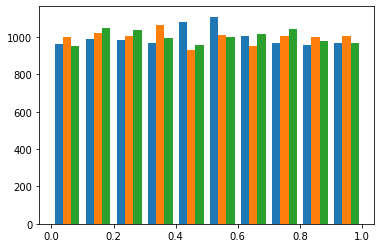

In [130]:
plt.hist(layer1['Y'])

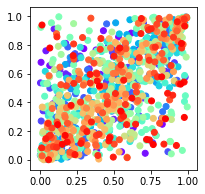

In [123]:
plt.figure(figsize=(3,3))
colors = cm.rainbow(x)
plt.scatter(layer1['Y'][::10,0],layer1['Y'][::10,1], color=colors[::10])

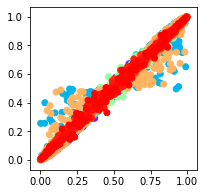

In [111]:
Y_new = np.array([V[1][...,0].cpu().numpy(),layer1['Y'][:,0]]).T

plt.figure(figsize=(3,3))
colors = cm.rainbow(x)
plt.scatter(*Y_new.T, color=colors)